In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from mcmctoolbox.functoolbox import flat

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

np.random.seed(1234)

In [2]:
# Load DataBase Locally
pdb_path = "../../posteriordb/posterior_database"
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-banana-test-banana")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]

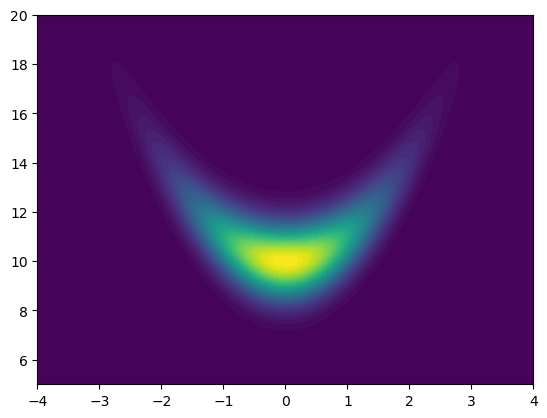

In [3]:
num = 1000
x = np.linspace(-4, 4, num)
y = np.linspace(5, 20, num)
X, Y = np.meshgrid(x, y)

Z = np.zeros((num, num))

for i in range(len(x)):
    for j in range(len(y)):
        Z[i, j] = np.exp(log_p(np.array([x[i], y[j]])))

plt.contourf(X, Y, Z.T, 50, cmap='viridis')
plt.savefig('Pic/banana_true.png', dpi=300)

In [7]:
gs_t = gs_chains.T
np.savetxt('Data/banana.csv', gs_t, delimiter=',')